In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#from utils.venn4 import venn4
#from gpcr_mapper.plot_gpcr_mapper import plot_gpcr_mapper
from scipy import stats
import ptitprince as pt
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [3]:

def fit_eval_model(df, formula):
    model_fit = smf.ols(formula, data=df).fit()
    print(f"Formula: {formula}\n")
    print(f"BIC: {model_fit.bic}\n")
    print(f"AIC: {model_fit.aic}\n")
    print(model_fit.summary())
    return model_fit

# Figure 1

## A: Expected variants

In [4]:
constraint = pd.read_csv('../data/constraint/zscores_hgnc_iuphar.tsv',sep='\t')
constraint['z_max'] = constraint['z_max'] = constraint[['z_lof','z_mis_pphen']].max(axis=1)
constraint.target_class.value_counts()
constraint[constraint.target_class!='None'].shape

(2982, 30)

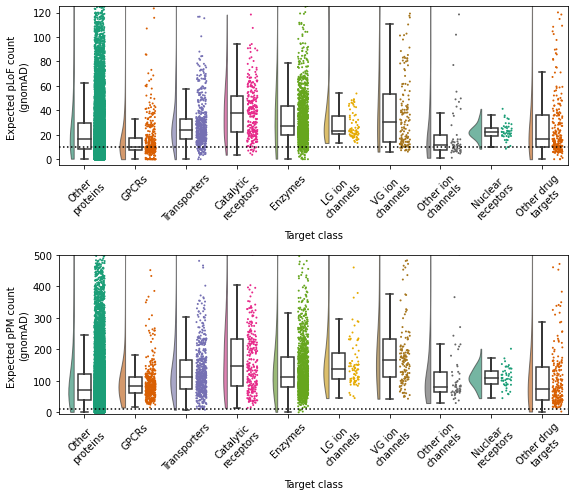

In [5]:


order = ['None', 'gpcr','transporter', 'catalytic_receptor', 'enzyme',  'lgic','vgic','other_ic',
       'nhr',   'other_protein',]
labels = ['Other\nproteins', 'GPCRs','Transporters', 'Catalytic\nreceptors', 'Enzymes',  
          'LG ion\nchannels','VG ion\nchannels', 'Other ion\nchannels',
       'Nuclear\nreceptors',   'Other drug\ntargets',]
fig, ax = plt.subplots(2, 1, figsize = (8, 7))
rc_params = dict(dodge = True,
    point_size = 2,
    point_jitter = 2,
    width_viol = 0.5,
    width_box = 0.25,
    alpha = 0.65,
    box_saturation=0.8,
    box_fliersize=0,
    move=0.3,
    palette='Dark2',
    bw = 0.5)

pt.RainCloud(data = constraint, x = 'target_class',y='exp_lof',order = order,ax=ax[0],**rc_params)
ax[0].set_xticks(ax[0].get_xticks(),labels, rotation=45)
ax[0].set_ylim((-5,125))
ax[0].set_xlim((-0.5, len(order)-0.5))
ax[0].hlines(10, -0.5, len(order)-0.5,color='k',linestyle='dotted')
ax[0].set_xlabel('Target class')


pt.RainCloud(data = constraint, x = 'target_class',y='exp_mis_pphen',order = order,ax=ax[1],**rc_params)


ax[1].set_xticks(ax[1].get_xticks(),labels, rotation=45)
ax[1].set_xlim((-0.5, len(order)-0.5))
ax[1].set_ylim((-5,500))
ax[1].hlines(10, -0.5, len(order)-0.5,color='k',linestyle='dotted')
ax[1].set_xlabel('Target class')
plt.tight_layout()

ax[0].set_ylabel('Expected pLoF count \n(gnomAD)')
ax[1].set_ylabel('Expected pPM count \n(gnomAD)')

plt.savefig('../plots/iuphar_all_families_expected.svg',format='svg')

In [6]:
family_counts = constraint.groupby('target_class').agg({
    'exp_lof':['median',stats.iqr],
    'exp_mis_pphen':['median',stats.iqr]}
)
family_counts['N'] = constraint.target_class.value_counts()
family_counts['plof_exp'] = \
    family_counts[('exp_lof','median')].astype(int).astype(str) + ' (' + \
    family_counts[('exp_lof','iqr')].astype(int).astype(str) + ')'
family_counts['ppm_exp'] = \
    family_counts[('exp_mis_pphen','median')].astype(int).astype(str) + ' (' + \
    family_counts[('exp_mis_pphen','iqr')].astype(int).astype(str) + ')'
family_counts = family_counts[['N','plof_exp','ppm_exp']]
total_counts = pd.DataFrame({
    'N':[constraint.shape[0]],
    'plof_exp':[str(int(constraint.exp_lof.median())) + ' (' \
        + str(int(stats.iqr(constraint.exp_lof)))+ ')'],
    'ppm_exp':[str(int(constraint.exp_mis_pphen.median())) + ' (' \
        + str(int(stats.iqr(constraint.exp_mis_pphen))) + ')']
})
counts = pd.concat([total_counts,family_counts])

counts.to_csv('../results/iuphar_expected_counts_median.tsv',sep='\t')

Formula: exp_lof_rank ~ C(target_class)

BIC: 5821.265214502773

AIC: 5742.769622397667

                            OLS Regression Results                            
Dep. Variable:           exp_lof_rank   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     109.8
Date:                Fri, 09 Jun 2023   Prob (F-statistic):          1.24e-201
Time:                        14:01:36   Log-Likelihood:                -2861.4
No. Observations:               18950   AIC:                             5743.
Df Residuals:                   18940   BIC:                             5821.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------

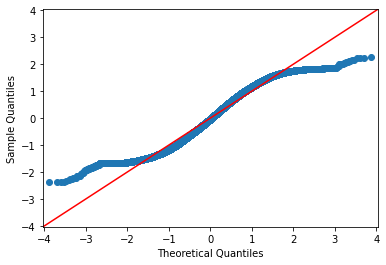

In [7]:
constraint['exp_lof_rank'] = constraint.exp_lof.rank(pct=True)
formulae = [
    'exp_lof_rank ~ C(target_class)'
]

models = []  
for formula in formulae:
    #models.append(fit_eval_model(constraint, formula))
    models.append(fit_eval_model(constraint[constraint.hgnc_symbol!='TTN'], formula))
    sm.qqplot(models[-1].resid, stats.t,fit=True, line="45")

Formula: exp_mis_pphen_rank ~ C(target_class)

BIC: 5699.536937546594

AIC: 5621.041345441488

                            OLS Regression Results                            
Dep. Variable:     exp_mis_pphen_rank   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     124.1
Date:                Fri, 09 Jun 2023   Prob (F-statistic):          6.52e-228
Time:                        14:02:00   Log-Likelihood:                -2800.5
No. Observations:               18950   AIC:                             5621.
Df Residuals:                   18940   BIC:                             5700.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------

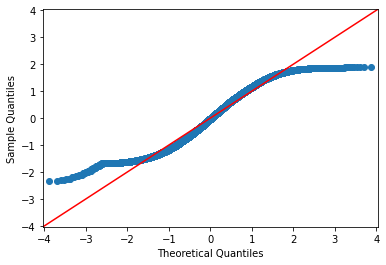

In [9]:
constraint['exp_mis_pphen_rank'] = constraint.exp_mis_pphen.rank(pct=True)
formulae = [
    'exp_mis_pphen_rank ~ C(target_class)'
]

models = []  
for formula in formulae:
    #models.append(fit_eval_model(constraint, formula))
    models.append(fit_eval_model(constraint[constraint.hgnc_symbol!='TTN'], formula))
    sm.qqplot(models[-1].resid, stats.t,fit=True, line="45")

Formula: exp_lof ~ C(target_class) + num_coding_exons + cds_length

BIC: 125650.73807077791

AIC: 125556.54336025179

                            OLS Regression Results                            
Dep. Variable:                exp_lof   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                 2.428e+04
Date:                Fri, 05 May 2023   Prob (F-statistic):               0.00
Time:                        16:31:50   Log-Likelihood:                -62766.
No. Observations:               18950   AIC:                         1.256e+05
Df Residuals:                   18938   BIC:                         1.257e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.02

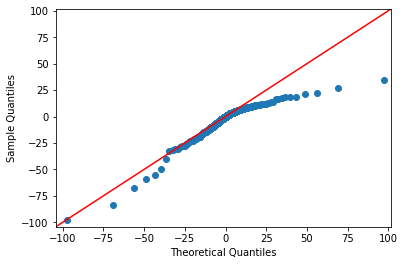

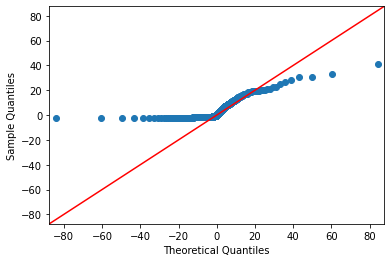

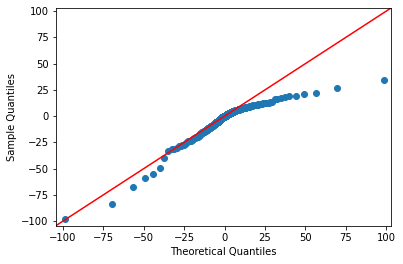

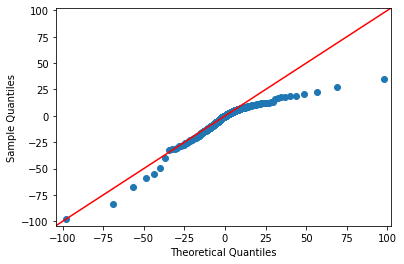

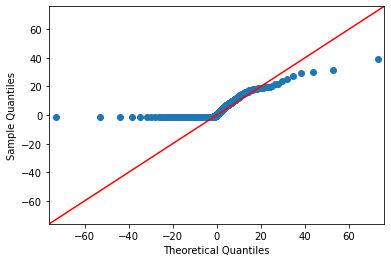

In [131]:
formulae = [
    'exp_lof ~ C(target_class) + num_coding_exons + cds_length',
    'exp_lof ~ C(target_class)',
    'exp_lof ~ num_coding_exons + cds_length',
    'exp_lof ~ is_gpcr + num_coding_exons + cds_length',
    'exp_lof ~ is_gpcr'
]

models = []  
for formula in formulae:
    #models.append(fit_eval_model(constraint, formula))
    models.append(fit_eval_model(constraint[constraint.hgnc_symbol!='TTN'], formula))
    print(stats.pearsonr(constraint[constraint.hgnc_symbol!='TTN']['exp_lof'].values, models[-1].fittedvalues))
    print(stats.pearsonr(models[-1].fittedvalues, models[-1].resid))
    sm.qqplot(models[-1].resid, stats.t,fit=True, line="45")

In [11]:
constraint.columns

Index(['Unnamed: 0', 'hgnc_symbol', 'hgnc_name', 'transcript', 'cds_length',
       'num_coding_exons', 'obs_syn', 'exp_syn', 'obs_mis', 'exp_mis',
       'obs_lof', 'exp_lof', 'obs_mis_pphen', 'exp_mis_pphen', 'z_syn',
       'oeuf_syn', 'z_mis', 'oeuf_mis', 'z_lof', 'oeuf_lof', 'z_mis_pphen',
       'oeuf_mis_pphen', 'rvis_score', 'phylop_score', 'phylop_score_primate',
       'mouse_lethal', 'clinvar_pathogenic', 'target_class', 'target_family',
       'z_max', 'exp_lof_rank', 'exp_mis_pphen_rank'],
      dtype='object')

In [135]:
print(constraint.groupby('is_gpcr').cds_length.median())
print(stats.mannwhitneyu(
    constraint[constraint.is_gpcr].cds_length,
    constraint[~constraint.is_gpcr].cds_length
))

print(constraint.groupby('is_gpcr').num_coding_exons.median())
print(stats.mannwhitneyu(
    constraint[constraint.is_gpcr].num_coding_exons,
    constraint[~constraint.is_gpcr].num_coding_exons
))

is_gpcr
False    1305.0
True     1156.5
Name: cds_length, dtype: float64
MannwhitneyuResult(statistic=3649369.0, pvalue=0.7792251559245793)
is_gpcr
False    7.0
True     2.0
Name: num_coding_exons, dtype: float64
MannwhitneyuResult(statistic=1767226.0, pvalue=1.8233816244376902e-67)


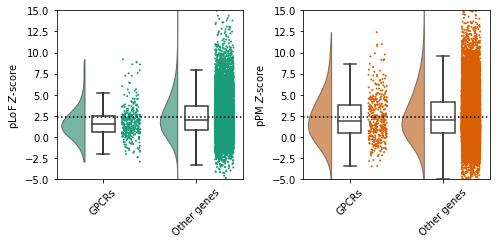

In [124]:
# # gnomAD genes which are underpowered
rc_params = dict(dodge = True,
    point_size = 2,
    point_jitter = 2,
    width_viol = 0.5,
    width_box = 0.25,
    alpha = 0.65,
    box_saturation=0.8,
    box_fliersize=0,
    move=0.3,
    bw = 0.5)


fig, ax = plt.subplots(1,2, figsize=(7,3.5))
constraint['is_gpcr'] = constraint['target_class'].isin(['gpcr'])
pt.RainCloud(data = constraint, x = 'is_gpcr',y='z_lof',order = [True, False],ax=ax[0],**rc_params, palette=sns.color_palette([sns.mpl_palette('Dark2')[0]]*2))
ax[0].set_xticks(ax[0].get_xticks(),['GPCRs','Other genes'], rotation=45)
ax[0].set_ylim((-5,15))
ax[0].set_xlim((-0.5, 1.5))
#ax[0].set_xlim((-0.5, len(order)-0.5))
ax[0].hlines(2.32, -0.5, len(order)-0.5,color='k',linestyle='dotted')
ax[0].set_xlabel('')


pt.RainCloud(data = constraint, x = 'is_gpcr',y='z_mis_pphen',order = [True, False],ax=ax[1],**rc_params, palette=sns.color_palette([sns.mpl_palette('Dark2')[1]]*2))


ax[1].set_xticks(ax[1].get_xticks(),['GPCRs','Other genes'], rotation=45)
ax[1].set_xlim((-0.5, 1.5))
ax[1].set_ylim((-5,15))
ax[1].hlines(2.32, -0.5, len(order)-0.5,color='k',linestyle='dotted')
ax[1].set_xlabel('')


ax[0].set_ylabel(r'pLoF $Z$-score')
ax[1].set_ylabel(r'pPM $Z$-score')
plt.tight_layout()

plt.savefig('../plots/iuphar_gpcrs_zscores.svg',format='svg')

Formula: exp_mis_pphen ~ C(target_class) + num_coding_exons + cds_length

BIC: 203286.186104613

AIC: 203191.9913940869

                            OLS Regression Results                            
Dep. Variable:          exp_mis_pphen   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     5830.
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        09:49:28   Log-Likelihood:            -1.0158e+05
No. Observations:               18950   AIC:                         2.032e+05
Df Residuals:                   18938   BIC:                         2.033e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0

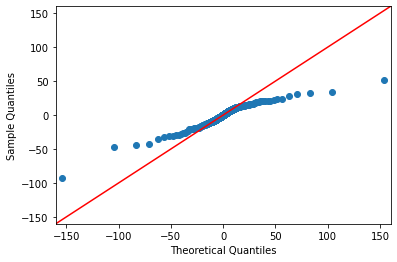

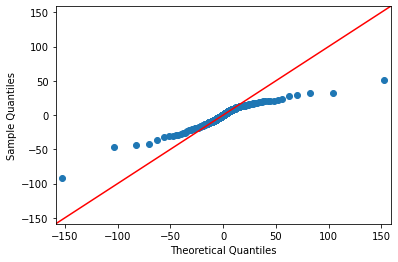

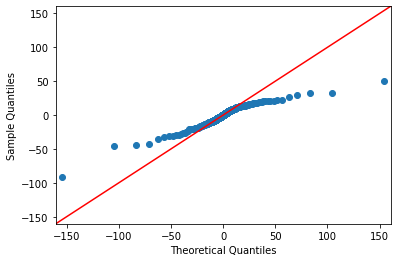

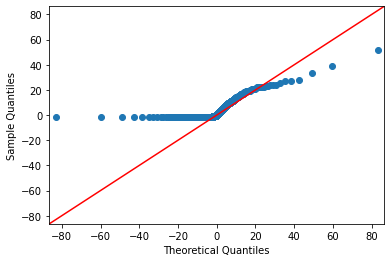

In [57]:
formulae = [
    'exp_mis_pphen ~ C(target_class) + num_coding_exons + cds_length',
    'exp_mis_pphen ~ num_coding_exons + cds_length',
    'exp_mis_pphen ~ is_gpcr + num_coding_exons + cds_length',
    'exp_mis_pphen ~ is_gpcr'
]
    
models = []  
for formula in formulae:
    models.append(fit_eval_model(constraint[constraint.hgnc_symbol!='TTN'], formula))
    sm.qqplot(models[-1].resid, stats.t,fit=True, line="45")

Formula: exp_mis ~ C(target_class) + num_coding_exons + cds_length

BIC: 212332.09086467576

AIC: 212237.89615414964

                            OLS Regression Results                            
Dep. Variable:                exp_mis   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                 3.314e+04
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        13:28:36   Log-Likelihood:            -1.0611e+05
No. Observations:               18950   AIC:                         2.122e+05
Df Residuals:                   18938   BIC:                         2.123e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.02

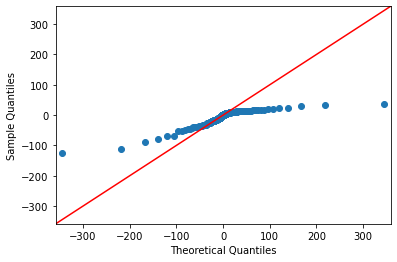

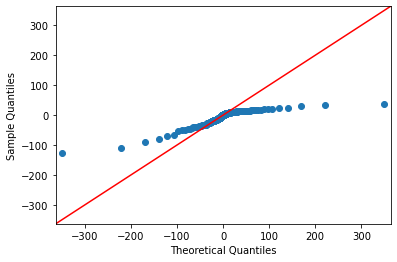

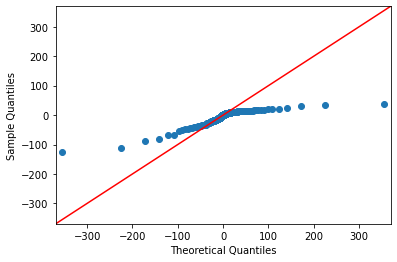

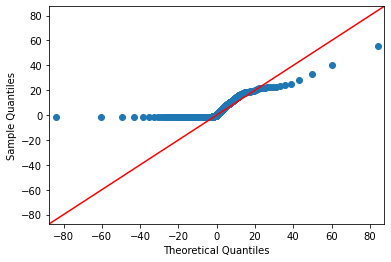

In [85]:
formulae = [
    'exp_mis ~ C(target_class) + num_coding_exons + cds_length',
    'exp_mis ~ num_coding_exons + cds_length',
    'exp_mis ~ is_gpcr + num_coding_exons + cds_length',
    'exp_mis ~ is_gpcr'
]
    
models = []  
for formula in formulae:
    models.append(fit_eval_model(constraint[constraint.hgnc_symbol!='TTN'], formula))
    sm.qqplot(models[-1].resid, stats.t,fit=True, line="45")

In [103]:
constraint['is_gpcr'] = constraint.target_class == 'gpcr'
print(constraint.is_gpcr.value_counts())

print(constraint.groupby(['is_gpcr'])[['exp_lof','exp_mis_pphen']].median())
constraint['lof_underpowered'] = constraint.exp_lof < 16.6
print((constraint.groupby(['is_gpcr']).lof_underpowered).aggregate(['mean','sum']))


print('Test for expected pLoF difference',
stats.mannwhitneyu(
    constraint[constraint.is_gpcr].exp_lof,
    constraint[~constraint.is_gpcr].exp_lof
))
print('Test for expected pPM difference',
    stats.mannwhitneyu(
        constraint[constraint.is_gpcr].exp_mis_pphen,
        constraint[~constraint.is_gpcr].exp_mis_pphen
))

False    18561
True       390
Name: is_gpcr, dtype: int64
          exp_lof  exp_mis_pphen
is_gpcr                         
False    18.31100         76.273
True     10.00725         83.165
             mean   sum
is_gpcr                
False    0.459027  8520
True     0.733333   286
Test for expected pLoF difference MannwhitneyuResult(statistic=2583363.5, pvalue=3.3394105653851e-22)
Test for expected pPM difference MannwhitneyuResult(statistic=3905399.0, pvalue=0.007475980683128948)


In [13]:
gpcrs = pd.read_csv('../data/gene_families/gpcr_genes_human_gpcrdb.tsv', sep = '\t')

In [21]:
constraint['is_gpcr'] = constraint.hgnc_symbol.isin(gpcrs.gene)
constraint.is_gpcr.value_counts()

constraint['is_rhodopsin_like_gpcr'] = constraint.hgnc_symbol.isin(gpcrs[gpcrs.receptor_class=='Class A (Rhodopsin)'].gene)
constraint.is_rhodopsin_like_gpcr.value_counts()

False    18669
True       282
Name: is_rhodopsin_like_gpcr, dtype: int64

In [23]:
constraint = constraint.merge(gpcrs[['gene','receptor_class']], left_on='hgnc_symbol', right_on='gene', how='left')

In [36]:
by_class = pd.DataFrame(
(    constraint.receptor_class.value_counts(),
    constraint.groupby(['receptor_class']).exp_lof.median(),
    constraint.groupby(['receptor_class']).exp_mis_pphen.median()
)).T
by_class.columns = ['num_genes','exp_lof','exp_mis_pphen']
by_class.sort_index().round().astype(int).to_csv('../results/median_by_class.csv')

In [45]:
constraint.columns

Index(['Unnamed: 0', 'hgnc_symbol', 'hgnc_name', 'transcript', 'cds_length',
       'num_coding_exons', 'obs_syn', 'exp_syn', 'obs_mis', 'exp_mis',
       'obs_lof', 'exp_lof', 'obs_mis_pphen', 'exp_mis_pphen', 'z_syn',
       'oeuf_syn', 'z_mis', 'oeuf_mis', 'z_lof', 'oeuf_lof', 'z_mis_pphen',
       'oeuf_mis_pphen', 'rvis_score', 'phylop_score', 'phylop_score_primate',
       'mouse_lethal', 'clinvar_pathogenic', 'target_class', 'target_family',
       'z_max', 'exp_lof_rank', 'exp_mis_pphen_rank', 'is_gpcr',
       'is_rhodopsin_like_gpcr', 'gene', 'receptor_class',
       'z_mis_pphen_top_quintile', 'z_lof_top_quintile'],
      dtype='object')

In [56]:
constraint[constraint.is_gpcr & (constraint.receptor_class=='Class A (Rhodopsin)')].sort_values('z_max',ascending=False)[['hgnc_symbol','z_lof','z_mis_pphen','mouse_lethal','clinvar_pathogenic']].sort_values('hgnc_symbol').to_csv('../results/top_rhodopsin_like_gpcrs.csv')

In [37]:
constraint['z_mis_pphen_top_quintile'] = constraint.z_mis_pphen > constraint.z_mis_pphen.quantile(0.8)
constraint['z_lof_top_quintile'] = constraint.z_lof > constraint.z_lof.quantile(0.8)

stats.contingency.crosstab(constraint[constraint.is_gpcr].z_mis_pphen_top_quintile, constraint[constraint.is_gpcr].z_lof_top_quintile)

((array([False,  True]), array([False,  True])),
 array([[321,  10],
        [ 39,  20]]))

In [41]:
stats.contingency.crosstab(constraint[constraint.is_gpcr & (constraint.receptor_class=='Class A (Rhodopsin)')].z_mis_pphen_top_quintile, constraint[constraint.is_gpcr & (constraint.receptor_class=='Class A (Rhodopsin)')].z_lof_top_quintile)

((array([False,  True]), array([False,  True])),
 array([[248,   1],
        [ 31,   2]]))

In [99]:
constraint.mouse_lethal.value_counts() / constraint.shape[0]

False    0.78323
True     0.21677
Name: mouse_lethal, dtype: float64

In [38]:
constraint.mouse_lethal.value_counts()

False    14843
True      4108
Name: mouse_lethal, dtype: int64

## B: z-scores

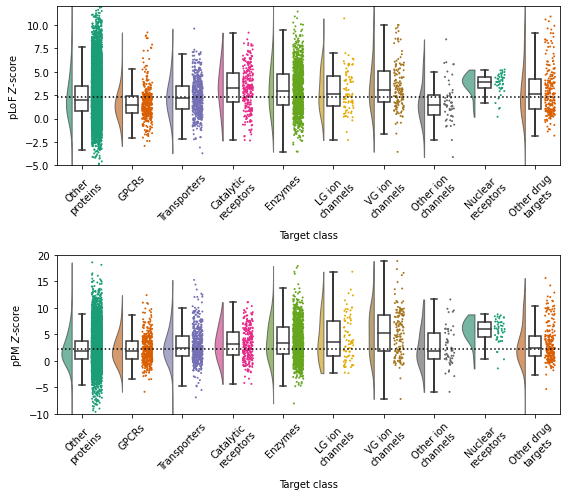

In [98]:
order = ['None', 'gpcr','transporter', 'catalytic_receptor', 'enzyme',  'lgic','vgic','other_ic',
       'nhr',   'other_protein',]
labels = ['Other\nproteins', 'GPCRs','Transporters', 'Catalytic\nreceptors', 'Enzymes',  
          'LG ion\nchannels','VG ion\nchannels', 'Other ion\nchannels',
       'Nuclear\nreceptors',   'Other drug\ntargets',]
fig, ax = plt.subplots(2, 1, figsize = (8, 7))
rc_params = dict(dodge = True,
    point_size = 2,
    point_jitter = 2,
    width_viol = 0.5,
    width_box = 0.25,
    alpha = 0.65,
    box_saturation=0.8,
    box_fliersize=0,
    move=0.3,
    palette='Dark2',
    bw = 0.5)

pt.RainCloud(data = constraint, x = 'target_class',y='z_lof',order = order,ax=ax[0],**rc_params)
ax[0].set_xticks(ax[0].get_xticks(),labels, rotation=45)
ax[0].set_xlim((-0.5, len(order)-0.5))
ax[0].set_ylim((-5, 12))
ax[0].hlines(2.33, -0.5, len(order)-0.5,color='k',linestyle='dotted')
ax[0].set_xlabel('Target class')


pt.RainCloud(data = constraint[constraint.exp_lof < 200], x = 'target_class',y='z_mis_pphen',order = order,ax=ax[1],**rc_params)

ax[1].hlines(2.33, -0.5, len(order)-0.5,color='k',linestyle='dotted')
ax[1].set_xticks(ax[1].get_xticks(),labels, rotation=45)
ax[1].set_xlim((-0.5, len(order)-0.5))
#ax[1].hlines(10, -0.5, len(order)-0.5,color='k',linestyle='dotted')
ax[1].set_xlabel('Target class')
ax[1].set_ylim((-10, 20))
plt.tight_layout()

ax[0].set_ylabel(r'pLoF $Z$-score')
ax[1].set_ylabel(r'pPM $Z$-score')

plt.savefig('../plots/iuphar_all_families_Zscore.svg',format='svg')

Formula: z_lof ~ C(target_class) + num_coding_exons + cds_length

BIC: 73488.5491159426

AIC: 73394.58585806015

                            OLS Regression Results                            
Dep. Variable:                  z_lof   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     1105.
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        09:58:46   Log-Likelihood:                -36685.
No. Observations:               18588   AIC:                         7.339e+04
Df Residuals:                   18576   BIC:                         7.349e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025    

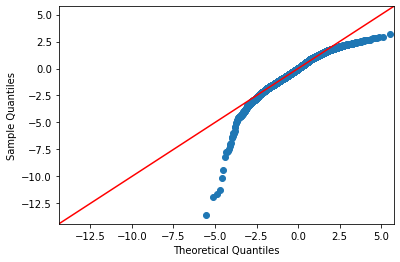

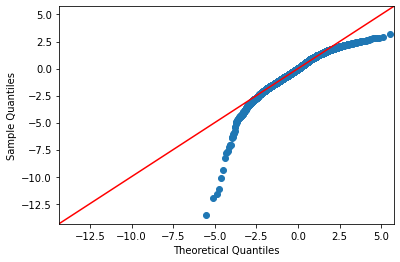

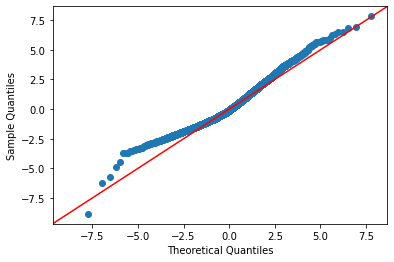

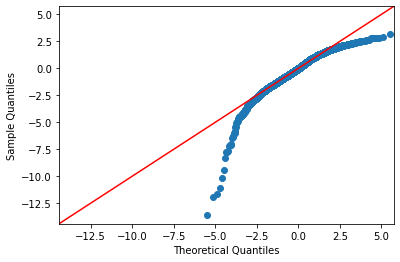

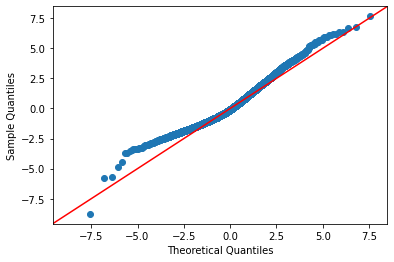

In [72]:
formulae = [
    'z_lof ~ C(target_class) + num_coding_exons + cds_length',
    'z_lof ~ num_coding_exons + cds_length',
    'z_lof ~ C(target_class)',
    'z_lof ~ is_gpcr + num_coding_exons + cds_length',
    'z_lof ~ is_gpcr'
]
models = []  
for formula in formulae:
    models.append(fit_eval_model(constraint[constraint.hgnc_symbol!='TTN'], formula))
    sm.qqplot(models[-1].resid, stats.t,fit=True, line="45")

Formula: z_mis_pphen ~ C(target_class) + num_coding_exons + cds_length

BIC: 91310.30040794626

AIC: 91216.18957829545

                            OLS Regression Results                            
Dep. Variable:            z_mis_pphen   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     298.0
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        09:59:38   Log-Likelihood:                -45596.
No. Observations:               18818   AIC:                         9.122e+04
Df Residuals:                   18806   BIC:                         9.131e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.

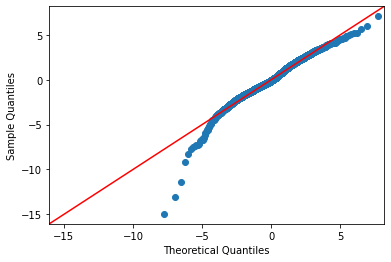

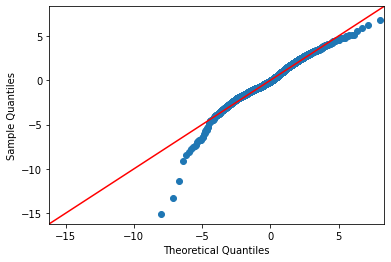

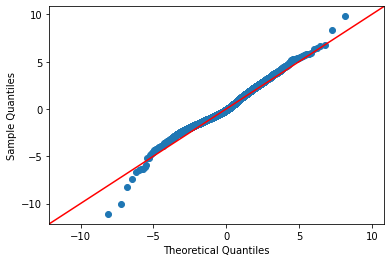

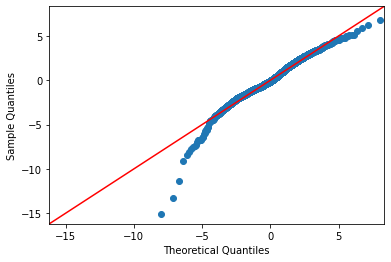

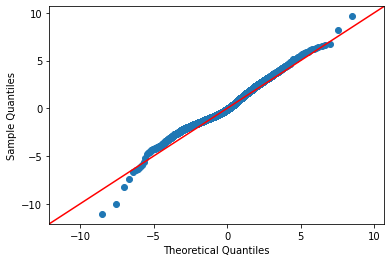

In [73]:
formulae = [
    'z_mis_pphen ~ C(target_class) + num_coding_exons + cds_length',
    'z_mis_pphen ~ num_coding_exons + cds_length',
    'z_mis_pphen ~ C(target_class)',
    'z_mis_pphen ~ is_gpcr + num_coding_exons + cds_length',
    'z_mis_pphen ~ is_gpcr'
]
models = []  
for formula in formulae:
    models.append(fit_eval_model(constraint[constraint.hgnc_symbol!='TTN'], formula))
    sm.qqplot(models[-1].resid, stats.t,fit=True, line="45")

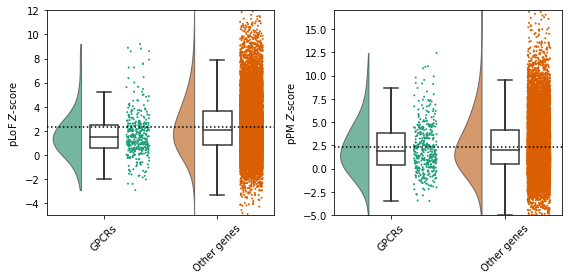

In [132]:
# # gnomAD genes which are underpowered

fig, ax = plt.subplots(1,2, figsize=(8,4))
pt.RainCloud(data = constraint, x = 'is_gpcr',y='z_lof',order = [True, False],ax=ax[0],**rc_params)
ax[0].set_xticks(ax[0].get_xticks(),['GPCRs','Other genes'], rotation=45)
ax[0].set_ylim((-5,12))
ax[0].set_xlim((-0.5, 1.5))
#ax[0].set_xlim((-0.5, len(order)-0.5))
ax[0].hlines(2.33, -0.5, len(order)-0.5,color='k',linestyle='dotted')
ax[0].set_xlabel('')


pt.RainCloud(data = constraint, x = 'is_gpcr',y='z_mis_pphen',order = [True, False],ax=ax[1],**rc_params)


ax[1].set_xticks(ax[1].get_xticks(),['GPCRs','Other genes'], rotation=45)
ax[1].set_xlim((-0.5, 1.5))
ax[1].set_ylim((-5,17))
ax[1].hlines(2.33, -0.5, len(order)-0.5,color='k',linestyle='dotted')
ax[1].set_xlabel('')


ax[0].set_ylabel(r'pLoF $Z$-score')
ax[1].set_ylabel(r'pPM $Z$-score')
plt.tight_layout()

In [75]:
print('Test for pLoF z-score difference',
stats.mannwhitneyu(
    constraint[constraint.is_gpcr].z_lof.fillna(0),
    constraint[~constraint.is_gpcr].z_lof.fillna(0)
))
print('Test for pPM z-score difference',
    stats.mannwhitneyu(
        constraint[constraint.is_gpcr].z_mis_pphen.fillna(0),
        constraint[~constraint.is_gpcr].z_mis_pphen.fillna(0)
))

Test for pLoF z-score difference MannwhitneyuResult(statistic=2830731.5, pvalue=1.6307063685979994e-13)
Test for pPM z-score difference MannwhitneyuResult(statistic=3500469.5, pvalue=0.26602964852169697)


In [114]:
pd.DataFrame(dict(
    is_gpcr = constraint.target_class == 'gpcr',
    z_max = constraint.z_max > constraint.z_max.quantile(0.8)
)).value_counts()

is_gpcr  z_max
False    False    14831
         True      3730
True     False      339
         True        51
dtype: int64

In [113]:
pd.DataFrame(dict(
    is_gpcr = constraint.target_class == 'gpcr',
    z_lof = constraint.z_lof > constraint.z_lof.quantile(0.8),
    z_mis_pphen = constraint.z_mis_pphen > constraint.z_mis_pphen.quantile(0.8)
)).value_counts()

is_gpcr  z_lof  z_mis_pphen
False    False  False          13609
         True   True            2441
         False  True            1264
         True   False           1247
True     False  False            321
                True              39
         True   True              20
                False             10
dtype: int64

# Correlation between predictors

In [83]:
print(stats.spearmanr(constraint.z_lof, constraint.z_mis_pphen,nan_policy='omit'))
constraint[['z_lof','z_mis_pphen','z_mis','rvis_score','phylop_score','phylop_score_primate']].corr(method='spearman')


SpearmanrResult(correlation=0.764466055080584, pvalue=0.0)


,z_lof,z_mis_pphen,z_mis,rvis_score,phylop_score,phylop_score_primate
z_lof,1.000000,0.764466,0.684792,-0.579865,0.509295,0.505790
z_mis_pphen,0.764466,1.000000,0.897370,-0.635855,0.569153,0.558157
z_mis,0.684792,0.897370,1.000000,-0.611014,0.588653,0.577204
rvis_score,-0.579865,-0.635855,-0.611014,1.000000,-0.538984,-0.560069
phylop_score,0.509295,0.569153,0.588653,-0.538984,1.000000,0.861376
phylop_score_primate,0.505790,0.558157,0.577204,-0.560069,0.861376,1.000000


## C,D: Z score tree plots

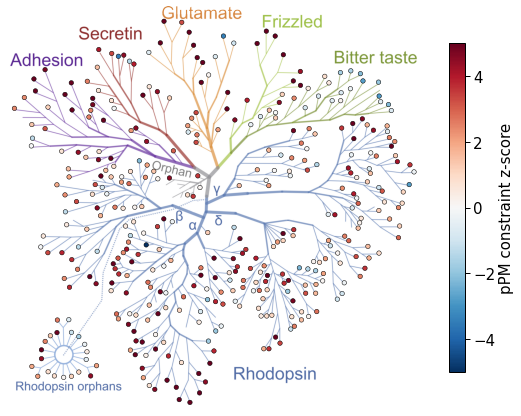

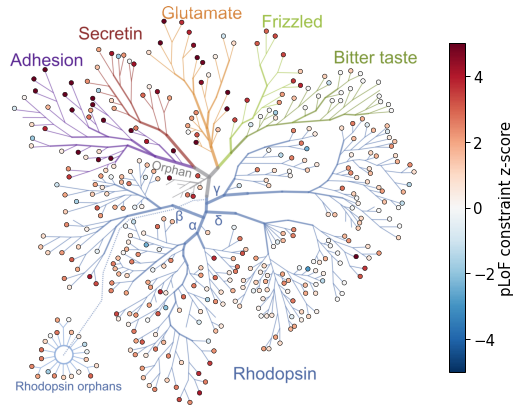

In [9]:
constraint = pd.read_csv("../data/constraint/gnomad/all_genes_constraint_zscores.tsv", sep = '\t', index_col=0)
gpcrs = pd.read_csv('../data/labels/gene_families/gpcr_genes_human_gpcrdb.tsv', sep = '\t')
constraint_gpcrs = constraint.rename(columns = {'gene':'gene_gnomad'}).merge(gpcrs)

mappings = pd.read_csv('gpcr_mapper/gpcr_treemapper_coords.txt',sep='\t')
df = constraint_gpcrs.merge(mappings)

df['label'] = 'Everything'

sns.set_context('paper')
ax = plot_gpcr_mapper(df.x, df.y, df['z_mis_pphen'], df.label,
    'pPM constraint z-score',
    marker_size = 20,cmap='RdBu_r',cscale=(-5, 5)
    )
ax.get_legend().remove()
plt.tight_layout()
plt.savefig('../plots/Fig2D_z_mis_pphen_treemapper.png',dpi=450)


sns.set_context('paper')
ax = plot_gpcr_mapper(df.x, df.y, df['z_lof'].fillna(0), df.label,
    'pLoF constraint z-score',
    marker_size = 20,cmap='RdBu_r',cscale=(-5, 5))
ax.get_legend().remove()
plt.tight_layout()
plt.savefig('../plots/Fig2C_z_plof_treemapper.png',dpi=450)

# Supplementary Figure 1

## A, B: expected variants tree plots

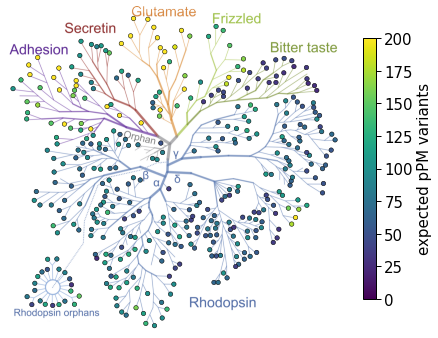

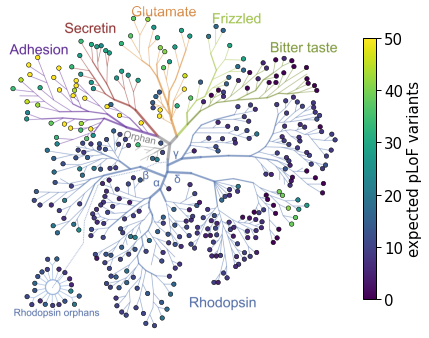

In [5]:
constraint = pd.read_csv("../data/constraint/gnomad/all_genes_constraint_zscores.tsv", sep = '\t', index_col=0)
gpcrs = pd.read_csv('../data/labels/gene_families/gpcr_genes_human_gpcrdb.tsv', sep = '\t')
constraint_gpcrs = constraint.rename(columns = {'gene':'gene_gnomad'}).merge(gpcrs)

mappings = pd.read_csv('gpcr_mapper/gpcr_treemapper_coords.txt',sep='\t')
df = constraint_gpcrs.merge(mappings)

df['label'] = 'Everything'

sns.set_context('paper')
ax = plot_gpcr_mapper(df.x, df.y, df['exp_mis_pphen'], df.label,
    'expected pPM variants',
    marker_size = 20,cmap='viridis',cscale=(0, 200))
ax.get_legend().remove()
plt.savefig('../plots/SuppFig1A_exp_mis_pphen_treemapper.png',dpi=450)


ax = plot_gpcr_mapper(df.x, df.y, df['exp_lof'].fillna(0), df.label,
    'expected pLoF variants',
    marker_size = 20,cmap='viridis',cscale=(0, 50))
ax.get_legend().remove()
plt.savefig('../plots/SuppFig1B_exp_plof_treemapper.png',dpi=450)

## C,D: gene length/exons

Fraction of single-exon genes
is_gpcr
False    0.103441
True     0.468031
Name: num_coding_exons, dtype: float64
Mean CDS length
is_gpcr
False    1269.0
True     1158.0
Name: cds_length, dtype: float64


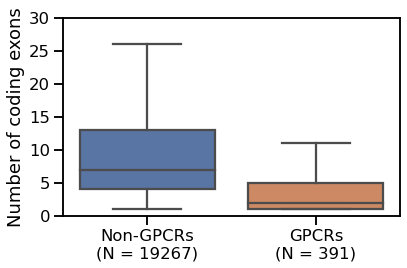

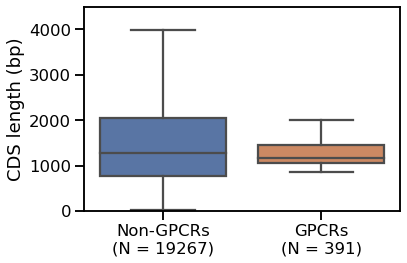

In [ ]:
gene_params = pd.read_csv('../data/constraint/gnomad/all_genes_constraint_gnomad.tsv',sep='\t',usecols=['gene','cds_length','num_coding_exons'])
gene_params = gene_params[~gene_params.gene.duplicated()]
gpcrs = pd.read_csv('../data/labels/gpcr_genes_human_gpcrdb.tsv',sep='\t')
gene_params['is_gpcr'] = gene_params.gene.isin(gpcrs.gene_gnomad)

print('Fraction of single-exon genes')
print((gene_params.num_coding_exons == 1).groupby(gene_params.is_gpcr).mean())
print('Mean CDS length')
print(gene_params.cds_length.groupby(gene_params.is_gpcr).median())

sns.set_palette('deep')
sns.boxplot(data = gene_params, y = 'num_coding_exons',x='is_gpcr',fliersize=0)
plt.ylim((0, 30))
plt.ylabel('Number of coding exons')
plt.xlabel('')
plt.xticks(
    plt.xticks()[0],
    [
        f'Non-GPCRs\n(N = {N_non_gpcrs})',
        f'GPCRs\n(N = {N_gpcrs})'
    ]
)
plt.tight_layout()
plt.savefig('../plots/SuppFig1C_exons.png',dpi=450)

plt.subplots()
sns.boxplot(data = gene_params, y = 'cds_length',x='is_gpcr',fliersize=0)
plt.ylim((0, 4500))
plt.ylabel('CDS length (bp)')
plt.xlabel('')
plt.xticks(
    plt.xticks()[0],
    [
        f'Non-GPCRs\n(N = {N_non_gpcrs})',
        f'GPCRs\n(N = {N_gpcrs})'
    ]
)
plt.tight_layout()
plt.savefig('../plots/SuppFig1D_cds_length.png',dpi=450)

In [4]:
gene_params = pd.read_csv('../data/constraint/gnomad/all_genes_constraint_gnomad.tsv',sep='\t',usecols=['gene','cds_length','num_coding_exons'])
gene_params = gene_params[~gene_params.gene.duplicated()]
gpcrs = pd.read_csv('../data/labels/gene_families/gpcr_genes_human_gpcrdb.tsv',sep='\t')
gene_params['is_gpcr'] = gene_params.gene.isin(gpcrs.gene_gnomad)

In [14]:
(rows, cols), tab = stats.contingency.crosstab(
    gene_params.is_gpcr, 
    gene_params.num_coding_exons == 1
)
stats.chi2_contingency(tab)

(513.7771114578925,
 9.559369409663398e-114,
 1,
 array([[17134.28090345,  2132.71909655],
        [  347.71909655,    43.28090345]]))

In [9]:
stats.mannwhitneyu(
    gene_params[gene_params.is_gpcr].cds_length.values,
    gene_params[~gene_params.is_gpcr].cds_length.values
)

MannwhitneyuResult(statistic=3916132.0, pvalue=0.17858617282297917)

# Other analyses

In [21]:
# Muscarinic and frizzled receptors
constraint = pd.read_csv('../data/constraint/gnomad/all_genes_constraint_zscores.tsv',sep='\t',index_col=0)
constraint = constraint[~constraint.gene.duplicated()]

gpcrs = pd.read_csv('../data/labels/gene_families/gpcr_genes_human_gpcrdb.tsv',sep='\t',index_col=0)
constraint['is_gpcr'] = constraint.gene.isin(gpcrs.gene_gnomad)

constraint = constraint[constraint.is_gpcr]
muscarinic_constraint = constraint[constraint.gene.str.startswith('CHRM')]
print(
    'Muscarinic receptors', 
    'n = ', muscarinic_constraint.shape[0],
    'n significant pPM = ', (muscarinic_constraint.z_mis_pphen > 2.32).sum(),
    'n significant pLoF = ', (muscarinic_constraint.z_lof > 2.32).sum()
)

frizzled_constraint = constraint[constraint.gene.str.startswith('FZD') | (constraint.gene =='SMO')]
print(
    'frizzled receptors', 
    'n = ', frizzled_constraint.shape[0],
    'n significant pPM = ', (frizzled_constraint.z_mis_pphen > 2.32).sum(),
    'n significant pLoF = ', (frizzled_constraint.z_lof > 2.32).sum()
)

Muscarinic receptors n =  5 n significant pPM =  5 n significant pLoF =  5
frizzled receptors n =  11 n significant pPM =  10 n significant pLoF =  8


In [20]:
# Highly constrained genes

constraint = pd.read_csv('../data/constraint/gnomad/all_genes_constraint_zscores.tsv',sep='\t',index_col=0)
constraint = constraint[~constraint.gene.duplicated()]

gpcrs = pd.read_csv('../data/labels/gene_families/gpcr_genes_human_gpcrdb.tsv',sep='\t',index_col=0)
constraint = constraint.rename(columns = {'gene':'gene_gnomad'})
constraint = constraint.merge(gpcrs)

print(constraint[constraint.z_lof > 5]['receptor_class'].value_counts())
print(constraint[constraint.z_mis_pphen > 5]['receptor_class'].value_counts())

print(list(constraint[(constraint.z_lof > 2.32) & (constraint.z_mis_pphen < 2.32)]['gene']))
print(list(constraint[(constraint.z_lof > 2.32) & (constraint.z_mis_pphen < 2.32)]['exp_lof']))

Class B2 (Adhesion)    13
Class C (Glutamate)     5
Class A (Rhodopsin)     1
Name: receptor_class, dtype: int64
Class A (Rhodopsin)    28
Class C (Glutamate)     9
Class B2 (Adhesion)     8
Class F (Frizzled)      6
Name: receptor_class, dtype: int64
['ADGRA3', 'ADGRG5', 'GPR101', 'LPAR3', 'GPR50', 'KISS1R', 'GPR63', 'TPRA1', 'GNRHR', 'GPR176']
[60.931, 23.028, 8.3028, 8.0019, 7.6151, 9.7161, 11.061, 16.769, 12.206, 15.179]
